In [1]:
!pip install torch torchvision tqdm

In [2]:
# Cell 2: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
import numpy as np


In [3]:
# Cell 3: Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Cell 4: Mount Google Drive (if your data is stored there)
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/CompVisProject/dataset.zip -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_1.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_2.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_3.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_4.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_5.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_6.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_7.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_8.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_036_aug_9.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_1.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_2.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_3.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_4.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_5.jpg  
  inflating: /content/dataset/Aldos Pics/T/T_037_aug_6.jpg  
  inflating: /content/dataset/Aldo

In [5]:
# Cell 5: Dataset Classes and Split Logic
class SignLanguageDatasetSplit:
    def __init__(self, data_dir, val_split=0.2, random_state=42):
        self.data_dir = data_dir
        self.val_split = val_split
        self.random_state = random_state

    def get_image_paths(self):
        """Get all image paths and their labels"""
        image_paths = []
        labels = []
        classes = sorted([d for d in os.listdir(self.data_dir)
                        if os.path.isdir(os.path.join(self.data_dir, d))])

        for class_name in classes:
            class_dir = os.path.join(self.data_dir, class_name)
            class_images = [os.path.join(class_dir, img)
                          for img in os.listdir(class_dir)
                          if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            image_paths.extend(class_images)
            labels.extend([class_name] * len(class_images))

        return image_paths, labels

    def create_dataset(self):
        """Create train and validation datasets without physical splitting"""
        image_paths, labels = self.get_image_paths()

        X_train, X_val, y_train, y_val = train_test_split(
            image_paths, labels,
            test_size=self.val_split,
            random_state=self.random_state,
            stratify=labels
        )

        # Clear memory
        del image_paths, labels
        gc.collect()

        return list(zip(X_train, y_train)), list(zip(X_val, y_val))

class VirtualSignLanguageDataset(Dataset):
    def __init__(self, data_pairs, transform=None):
        self.data_pairs = data_pairs
        self.transform = transform
        self.classes = sorted(list(set([label for _, label in data_pairs])))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img_path, label = self.data_pairs[idx]
        # Use PIL's memory-efficient loading
        with Image.open(img_path) as img:
            image = img.convert('RGB')
            if self.transform:
                image = self.transform(image)
        return image, self.class_to_idx[label]


In [6]:
# Cell 6: Model Creation and Helper Functions
def create_model(num_classes):
    # Load pre-trained VGG16 with memory efficiency
    model = models.vgg16(pretrained=True)

    # Freeze most layers to save memory during training
    for param in model.features.parameters():
        param.requires_grad = False

    # Only train the last few layers
    for param in model.features[-4:].parameters():
        param.requires_grad = True

    # Replace classifier
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)

    return model

In [7]:
# Cell 7: Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                    factor=0.1, patience=3,
                                                    verbose=True)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Mixed precision training
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Clear memory
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                # Clear memory
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        scheduler.step(val_acc)

        # Save best model (with memory efficiency)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'class_to_idx': train_loader.dataset.class_to_idx,
            }, 'best_model.pth')

    return model, history

In [8]:
# Cell 8: Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='train')
    plt.plot(history['val_acc'], label='val')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
# Cell 9: Set up data transforms and create datasets
# Update this path to match your Google Drive structure
DATA_DIR = '/content/dataset/Aldos Pics'

# Memory-efficient data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset splits
dataset_splitter = SignLanguageDatasetSplit(DATA_DIR)
train_data, val_data = dataset_splitter.create_dataset()

# Create virtual datasets
train_dataset = VirtualSignLanguageDataset(train_data, transform=train_transform)
val_dataset = VirtualSignLanguageDataset(val_data, transform=val_transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

Training samples: 17200
Validation samples: 4301
Number of classes: 24


In [10]:
# Cell 10: Create dataloaders with memory efficiency
train_loader = DataLoader(
    train_dataset,
    batch_size=16,  # Reduced batch size for memory efficiency
    shuffle=True,
    num_workers=2,
    pin_memory=True  # Faster data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [11]:
# Cell 11: Initialize model and training parameters
# Clear any existing models from memory
gc.collect()
torch.cuda.empty_cache()

# Create model
model = create_model(num_classes=len(train_dataset.classes))
model = model.to(device)

# Training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.features[-4:].parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s]


In [12]:
# Cell 12: Train the model
model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/1075 [00:00<?, ?it/s]

<ipython-input-7-a3680f5a99ca>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision training


Train Loss: 0.5753 Acc: 0.8530


Validation:   0%|          | 0/269 [00:00<?, ?it/s]

<ipython-input-7-a3680f5a99ca>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Loss: 0.1376 Acc: 0.9730

Epoch 2/10


Training:   0%|          | 0/1075 [00:00<?, ?it/s]

Train Loss: 0.2631 Acc: 0.9607


Validation:   0%|          | 0/269 [00:00<?, ?it/s]

Val Loss: 0.1334 Acc: 0.9870

Epoch 3/10


Training:   0%|          | 0/1075 [00:00<?, ?it/s]

Train Loss: 0.2715 Acc: 0.9702


Validation:   0%|          | 0/269 [00:00<?, ?it/s]

Val Loss: 0.1195 Acc: 0.9849

Epoch 4/10


Training:   0%|          | 0/1075 [00:00<?, ?it/s]

Train Loss: 0.2181 Acc: 0.9793


Validation:   0%|          | 0/269 [00:00<?, ?it/s]

Val Loss: 0.0911 Acc: 0.9919

Epoch 5/10


Training:   0%|          | 0/1075 [00:00<?, ?it/s]

Train Loss: 0.2871 Acc: 0.9780


Validation:   0%|          | 0/269 [00:00<?, ?it/s]

Val Loss: 0.2051 Acc: 0.9877

Epoch 6/10


Training:   0%|          | 0/1075 [00:00<?, ?it/s]

Train Loss: 0.3180 Acc: 0.9825


Validation:   0%|          | 0/269 [00:00<?, ?it/s]

Val Loss: 0.1910 Acc: 0.9909

Epoch 7/10


Training:   0%|          | 0/1075 [00:00<?, ?it/s]

Train Loss: 0.2395 Acc: 0.9869


Validation:   0%|          | 0/269 [00:00<?, ?it/s]

Val Loss: 0.1077 Acc: 0.9926

Epoch 8/10


Training:   0%|          | 0/1075 [00:00<?, ?it/s]

Train Loss: 0.1902 Acc: 0.9891


Validation:   0%|          | 0/269 [00:00<?, ?it/s]

Val Loss: 0.1911 Acc: 0.9877

Epoch 9/10


Training:   0%|          | 0/1075 [00:00<?, ?it/s]

Train Loss: 0.3304 Acc: 0.9870


Validation:   0%|          | 0/269 [00:00<?, ?it/s]

Val Loss: 0.1742 Acc: 0.9933

Epoch 10/10


Training:   0%|          | 0/1075 [00:00<?, ?it/s]

Train Loss: 0.3233 Acc: 0.9880


Validation:   0%|          | 0/269 [00:00<?, ?it/s]

Val Loss: 0.1453 Acc: 0.9958


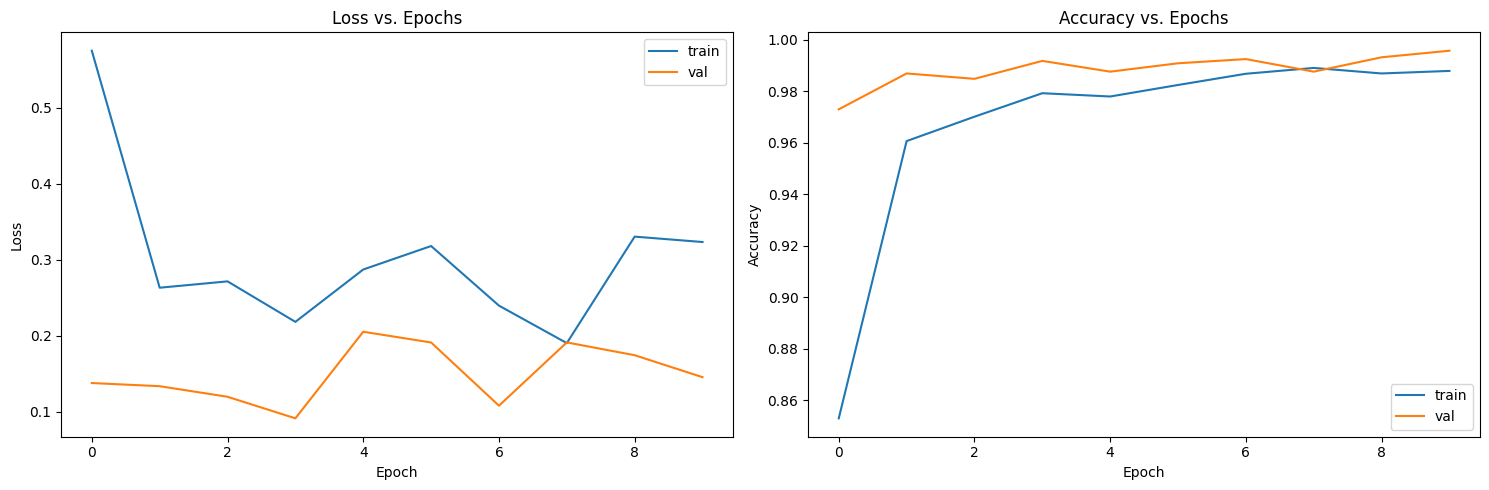

In [13]:
# Cell 13: Plot results
plot_training_history(history)

In [15]:
# Cell 14: Save final model and clean up
final_model_path = '/content/best_model.pth'
os.makedirs(os.path.dirname(final_model_path), exist_ok=True)

# Save model efficiently
torch.save({
    'model_state_dict': model.state_dict(),
    'class_to_idx': train_dataset.class_to_idx,
    'idx_to_class': {v: k for k, v in train_dataset.class_to_idx.items()},
    'num_classes': len(train_dataset.classes)
}, final_model_path)

# Clear memory
del model
gc.collect()
torch.cuda.empty_cache()

print(f"Model saved to {final_model_path}")

Model saved to /content/best_model.pth
